# **Análise do não comparecimento de pacientes à consultas médicas**

Neste projeto, vou construir um modelo de *Machine Learning* para prever se um paciente vai ou não comparecer a consulta médica que tem agendada. Para isso, vou utilizar o conjunto de dados disponibilizado no site do [Kaggle](https://www.kaggle.com/joniarroba/noshowappointments).

## **Importando as bibliotecas necessárias e o conjunto de dados**

In [1]:
# Importando as bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

from xgboost import XGBClassifier

from imblearn.under_sampling import RandomUnderSampler

from yellowbrick.classifier import ROCAUC

# Configurando o notebook
%matplotlib inline
sns.set(style='white')

# Removendo avisos
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Importando o conjunto de dados
df = pd.read_csv("https://raw.githubusercontent.com/dinopolo/med_appointment_app/main/Dataset/med_appointment_data.csv")

## **Análise Exploratória dos Dados**

**Primeiras Entradas**

In [3]:
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


Pelas primeiras entradas, podemos notar algumas variáveis que não acrescentam informações úteis ao nosso projeto como `PatientId` e `AppointmentID`. Além disso a variável `Neighbourhood` é o local da consulta, se tivéssemos o local onde paciente mora poderíamos criar uma nova variável e determinar a distância que o paciente percorre até o local da consulta, no entanto como não temos essa informação, a variável `Neighbourhood` também não acrescenta nenhuma informação.

In [4]:
# Armazenando as colunas a serem eliminadas posteriormente
eliminadas = ['PatientId', 'AppointmentID', 'Neighbourhood']

**Tipos das variáveis**

In [5]:
df.dtypes

PatientId         float64
AppointmentID       int64
Gender             object
ScheduledDay       object
AppointmentDay     object
Age                 int64
Neighbourhood      object
Scholarship         int64
Hipertension        int64
Diabetes            int64
Alcoholism          int64
Handcap             int64
SMS_received        int64
No-show            object
dtype: object

Percebe-se que os tipos das variáveis estão de acordo com o esperado, com exceção das variáveis `ScheduledDay` e `AppointmentDay`, portanto vou transformá-las para datetime:

In [6]:
# Convertendo ScheduledDay e AppointmentDay de object para datetime
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay']).dt.date.astype('datetime64[ns]')
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay']).dt.date.astype('datetime64[ns]')

**Criando nova variável com a diferença entre ScheduledDay e AppointmentDay**

Para um melhor entendimento, `ScheduledDay` é o dia em que a conulta foi marcada e `AppointmentDay` é o dia que a consulta ocorreu (ou deveria ocorrer), assim vamos criar a variável `dias_ate_consulta` subtraindo a variável `ScheduledDay` da variável `AppointmentDay` e investigar melhor essa nova variável.

In [7]:
# Criando a variável
df['dias_ate_consulta'] = df['AppointmentDay'] - df['ScheduledDay']

In [8]:
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,dias_ate_consulta
0,2.987250e+13,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No,0 days
1,5.589978e+14,5642503,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No,0 days
2,4.262962e+12,5642549,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No,0 days
3,8.679512e+11,5642828,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,0 days
4,8.841186e+12,5642494,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No,0 days


Ainda, iremos remover as variáveis `ScheduledDay` e `AppointmentDay` do conjunto de dados, pois elas já estão subentendidas na variável `dias_ate_consulta`.

In [9]:
eliminadas.extend(('AppointmentDay', 'ScheduledDay'))

Com exceção das variáveis a serem eliminadas, vou avaliar cada variável para verificar se há entradas anômalas ou estranhas no conjunto de dados. Mas antes, vou renomear cada variável passando para o idioma Português:

In [10]:
df.rename(columns={"Gender": "genero", "Age": "idade", "Scholarship": "auxilio_governamental", "Hipertension": "hipertensao", "Diabetes": "diabetes", "Alcoholism": "alcoolismo", 
                  "Handcap": "pcd", "SMS_received": "sms_recebido", "No-show": "nao_compareceu"}, inplace=True)

**Verificação dos valores ausentes**

In [11]:
# Valores ausentes
df.isnull().sum()

PatientId                0
AppointmentID            0
genero                   0
ScheduledDay             0
AppointmentDay           0
idade                    0
Neighbourhood            0
auxilio_governamental    0
hipertensao              0
diabetes                 0
alcoolismo               0
pcd                      0
sms_recebido             0
nao_compareceu           0
dias_ate_consulta        0
dtype: int64

## **Preparação dos Dados**

In [12]:
# Criando uma cópia do conjunto de dados
df_clean = df.copy()

In [13]:
# Removendo as colunas desnecessárias
df_clean.drop(columns = eliminadas, inplace=True)

Convertendo a coluna `dias_ate_consulta` de *timedelta* para *integer*:

In [14]:
df_clean['dias_ate_consulta'] = pd.to_numeric(df_clean['dias_ate_consulta'].dt.days, downcast='integer')

Vou verificar cada variável para verificar se há entradas que podem ser consideradas estranhas:

**Variável `genero`**

In [15]:
df_clean["genero"].unique()

array(['F', 'M'], dtype=object)

**Variável `idade`**

In [16]:
sorted(df_clean["idade"].unique())

[-1,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 102,
 115]

Como podemos perceber na variável `idade` há entradas que podem ser consideradas estranhas como a idade de -1, pois não há idades negativas e a idade de 115, pois é extremamente raro uma pessoa viver até os 115 anos. Sendo assim, vamos eliminar as entradas que têm esses valores, pois é bem provável que possa ter ocorrido algum tipo de erro no momento da coleta dessas entradas. Assim:

In [17]:
df_clean = df_clean[(df_clean["idade"] >= 0) | (df_clean["idade"] < 115)]

**Variável `auxilio_governamental`**

In [18]:
df_clean["auxilio_governamental"].unique()

array([0, 1], dtype=int64)

**Variável `hipertensao`**

In [19]:
df_clean["hipertensao"].unique()

array([1, 0], dtype=int64)

**Variável `diabetes`**

In [20]:
df_clean["diabetes"].unique()

array([0, 1], dtype=int64)

**Variável `alcoolismo`**

In [21]:
df_clean["alcoolismo"].unique()

array([0, 1], dtype=int64)

**Variável `pcd`**

In [22]:
df_clean["pcd"].unique()

array([0, 1, 2, 3, 4], dtype=int64)

Como a variável `pcd` significa Pessoa com Deficiência e temos cinco tipos de entrada (0, 1, 2, 3 e 4) para essa variável, provavelmente, 0 significa sem deficiência e 1, 2, 3 e 4 algum tipo de deficiência, no entanto, não explicitada qual é o tipo, vou transformar essa variável para categórica binária como sendo 0 sem deficiência e 1 com deficiência, assim:

In [23]:
df_clean["pcd"] = df_clean["pcd"].replace([1, 2, 3, 4], 1)

**Variável `sms_recebido`**

In [24]:
df_clean["sms_recebido"].unique()

array([0, 1], dtype=int64)

**Variável `nao_compareceu`**

In [25]:
df_clean["nao_compareceu"].unique()

array(['No', 'Yes'], dtype=object)

**Variável `dias_ate_consulta`**

In [26]:
sorted(df_clean["dias_ate_consulta"].unique())

[-6,
 -1,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 101,
 102,
 103,
 104,
 105,
 107,
 108,
 109,
 110,
 111,
 112,
 115,
 117,
 119,
 122,
 123,
 125,
 126,
 127,
 132,
 133,
 139,
 142,
 146,
 151,
 155,
 162,
 169,
 176,
 179]

Como podemos perceber, há dias negativos, no entanto isso não é possível, pois não pode haver dias até a consulta após a consulta já ter ocorrido, sendo assim vamos eliminar as entradas com esses valores:

In [27]:
df_clean = df_clean[df_clean["dias_ate_consulta"] >= 0]

**Verificação do balanceamento da variável objetivo**

A variável objetivo do conjunto de dados é a `No-show`, com isso vamos verificar o seu balanceamento:

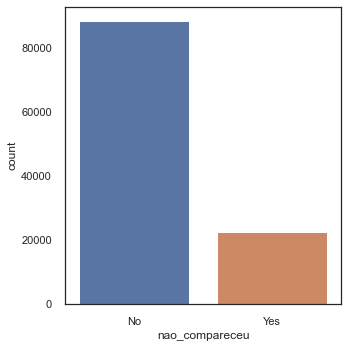

In [28]:
# Construindo a figura
fig, ax = plt.subplots(figsize=(5,5))

# Countplot para a variável No-show
sns.countplot(df_clean["nao_compareceu"], ax=ax)

plt.tight_layout();

**Preparando as variáveis `genero` e `nao_compareceu` para a construção do modelo de *Machine Learning***

Para a variável `genero`, F (Female ou Mulher) vou substituir por 0 e M (Male ou Homem) vou substituir por 1; e para a variável `nao_compareceu` No (Compareceu à consulta) vou substituir por 0 e Yes (Não compareceu à consulta) vou substituir por 1.

In [29]:
df_clean["genero"].replace({'F': 0, 'M': 1}, inplace=True)
df_clean["nao_compareceu"].replace({'No': 0, 'Yes': 1}, inplace=True)

## **Construção do Modelo de *Machine Learning***

Para a construção do modelo de *Machine Learning*, não será feito normalização ou padronização nas variáveis do conjunto de dados, pois como utilizarei apenas o modelo de *Random Forest*, esse tipo de modelo não é sensível a variação do conjunto de dados.

Agora, vou separar os dados em treino e teste:

In [30]:
# Separando as variáveis independentes e a variável objetivo No-show
X = df_clean.drop('nao_compareceu', axis=1)
y = df_clean['nao_compareceu']

# Separando o conjunto de dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [31]:
X_train.columns

Index(['genero', 'idade', 'auxilio_governamental', 'hipertensao', 'diabetes',
       'alcoolismo', 'pcd', 'sms_recebido', 'dias_ate_consulta'],
      dtype='object')

Ainda, é necessário realizar o balanceamento dos dados de treino e para isso vou utilizar o método *Under Sampling*:

Entradas da variável nao_compareceu após o balanceamento:
0    16735
1    16735
Name: nao_compareceu, dtype: int64 



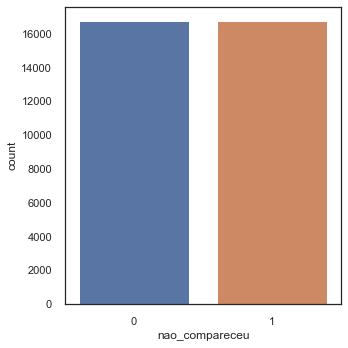

In [32]:
# Modelo para balancear os dados
und = RandomUnderSampler()

X_und, y_und = und.fit_sample(X_train, y_train)

# Verificando o balanceamento dos dados
print("Entradas da variável nao_compareceu após o balanceamento:")
print(pd.Series(y_und).value_counts(), "\n")

# Plotando a nova distribuição da variável No-show
fig, ax = plt.subplots(figsize=(5, 5))

sns.countplot(pd.Series(y_und), ax=ax)

plt.tight_layout()

**XGBoost**

Vou definir `learning_rate = 0.1` e ajustar o parâmetro `n_estimators`:

In [33]:
# Modelo XGBClassifier
xgb_model = XGBClassifier(learning_rate = 0.1, verbosity = 0)

# Ajustando o melhor valor para n_estimators
par = {'n_estimators': range(25, 1000, 25)}

xgb_clf = GridSearchCV(xgb_model, par, cv=ShuffleSplit(n_splits=1, test_size=0.3, random_state=20))
xgb_clf.fit(X_und, y_und)

# Armazenando o melhor ajuste de n_estimators
n_est = xgb_clf.best_params_['n_estimators']

# Visualizar o melhor ajuste
print("Melhor ajuste: {}".format(xgb_clf.best_params_))

Melhor ajuste: {'n_estimators': 25}


Agora, vou ajustar os parâmetros `max_depth` e `min_child_weight`:

In [34]:
# Modelo XGBClassifier
xgb_model = XGBClassifier(learning_rate = 0.1, n_estimators = n_est, verbosity = 0)

# Ajustando o melhor valor para n_estimators
par = {
    'max_depth': range(2, 10, 1), 
    'min_child_weight': range(1, 6, 1)
    }

xgb_clf = GridSearchCV(xgb_model, par, cv=ShuffleSplit(n_splits=1, test_size=0.3, random_state=20))
xgb_clf.fit(X_und, y_und)

# Armazenando o melhor ajuste de max_depth
m_depth = xgb_clf.best_params_['max_depth']
mcw = xgb_clf.best_params_['min_child_weight']

# Visualizar o melhor ajuste
print("Melhores ajustes: {}".format(xgb_clf.best_params_))

Melhores ajustes: {'max_depth': 5, 'min_child_weight': 1}


Ajustando o parâmetro `gamma`:

In [35]:
# Modelo XGBClassifier
xgb_model = XGBClassifier(learning_rate = 0.1, n_estimators = n_est, max_depth = m_depth, min_child_weight = mcw, verbosity = 0)

# Ajustando o melhor valor para num_leaves
par = {'gamma':[i/10.0 for i in range(0,5)]}

xgb_clf = GridSearchCV(xgb_model, par, cv=ShuffleSplit(n_splits=1, test_size=0.3, random_state=20))
xgb_clf.fit(X_und, y_und)

# Armazenando o melhor ajuste de num_leaves
gam = xgb_clf.best_params_['gamma']

# Visualizar o melhor ajuste
print("Melhor ajuste: {}".format(xgb_clf.best_params_))

Melhor ajuste: {'gamma': 0.0}


Agora, vou ajustar o parâmetro `learning_rate`:

In [36]:
# Modelo XGBClassifier
xgb_model = XGBClassifier(n_estimators = n_est, max_depth = m_depth, min_child_weight = mcw, gamma = gam, verbosity = 0)

# Ajustando o melhor valor para num_leaves
par = {'learning_rate':[0.001, 0.01, 0.1, 1, 10]}

xgb_clf = GridSearchCV(xgb_model, par, cv=ShuffleSplit(n_splits=1, test_size=0.3, random_state=20))
xgb_clf.fit(X_und, y_und)

# Armazenando o melhor ajuste de num_leaves
l_rate = xgb_clf.best_params_['learning_rate']

# Visualizar o melhor ajuste
print("Melhor ajuste: {}".format(xgb_clf.best_params_))

Melhor ajuste: {'learning_rate': 0.1}


Agora, com os parâmetros ajustados, vamos treinar o modelo:

In [37]:
# Construindo o modelo XGBClassifier
xgb_model = XGBClassifier(learning_rate = l_rate, n_estimators = n_est, max_depth = m_depth, min_child_weight = mcw, gamma = gam, verbosity = 0)

# Fit (ajuste) do modelo
xgb_model.fit(X_und, y_und)

# Fazendo previsões
y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)

Assim, vou avaliar o modelo utilizando a Acurácia, a AUC (Área Sob a Curva) e a Matriz de Confusão, também vou plotar a curva ROC para ter uma melhor visualização da AUC.

In [38]:
print("Acurácia:\t{}%".format(round(accuracy_score(y_test, y_pred) * 100, 2)))
print("Área sob a curva (AUC):\t{}%".format(round(roc_auc_score(y_test, y_pred) * 100, 2)))

Acurácia:	58.01%
Área sob a curva (AUC):	67.63%


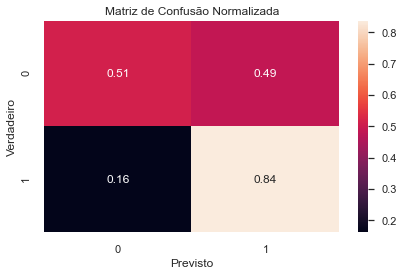

In [39]:
# Matriz de confusão
fig, ax = plt.subplots()

sns.heatmap(confusion_matrix(y_test, y_pred, normalize='true'), annot=True, ax=ax)

ax.set_title('Matriz de Confusão Normalizada')
ax.set_ylabel('Verdadeiro')
ax.set_xlabel('Previsto')

plt.tight_layout()

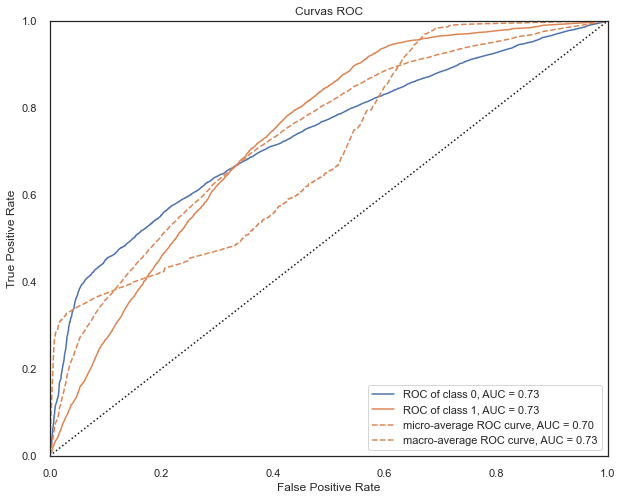

In [40]:
# Plotando a curva ROC:
fig, ax = plt.subplots(figsize=(10,8))
vis_rl = ROCAUC(xgb_model, classes=[0, 1], title="Curvas ROC")

vis_rl.fit(X_und, y_und); # Ajusta os dados de treino ao visualizador
vis_rl.score(X_test, y_test); # Avalia o modelo com os dados de teste
vis_rl.show(); # Finaliza e mostra a figura

**Exportando o modelo XGBoost**

In [41]:
# Exportando o modelo
file_name = "xgbclassifier.pkl"

# Salvando
pickle.dump(xgb_model, open(file_name, "wb"))